# Evaluation script and visualizations

In [1]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import torchvision.models as models
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights, MobileNet_V3_Small_Weights
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('../')
from utils.dataloader import get_dataloaders

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
class_dict = {
    0: "Surprise",
    1: "Fear",
    2: "Disgust",
    3: "Happiness",
    4: "Sadness",
    5: "Anger",
    6: "Neutral"
}

DATA_DIR = '../data/RAF/Image/aligned/'
TRAIN_LABELS_PATH = '../data/RAF/EmoLabel/emo_label_train.csv'
TEST_LABELS_PATH = '../data/RAF/EmoLabel/emo_label_test.csv'
TRAIN_DISTRIBUTION_PATH = '../data/RAF/EmoLabel/emo_distribution_train.csv'
TEST_DISTRIBUTION_PATH = '../data/RAF/EmoLabel/emo_distribution_test.csv'

MODEL_PATH = '../models/mobilenetv3_final.pt'
model_size = 'small'

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [3]:
_, _, test_loader = get_dataloaders(DATA_DIR, TRAIN_LABELS_PATH, TEST_LABELS_PATH, TRAIN_DISTRIBUTION_PATH, TEST_DISTRIBUTION_PATH, batch_size=256, num_workers=8)

if model_size == 'small':
    model = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
else:
    model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 7)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

y_true = []
y_pred = []
images = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels, distribution = data
        inputs, labels, distribution = inputs.to(device), labels.to(device), distribution.to(device)

        with autocast():
            outputs = model(inputs)
        confidences = torch.max(torch.softmax(outputs, dim=1), dim=1)
        predicted = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        for j in range(inputs.size()[0]):
            img = inputs[j].cpu().numpy().transpose(1, 2, 0)
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize image
            pred_label = class_dict[predicted[j].item()]
            true_label = class_dict[labels[j].item()]
            confidence = confidences[0][j].item()
            images.append((img, pred_label, true_label, confidence))
            break

# Basic metrics
print(classification_report(y_true, y_pred, target_names=class_dict.values()))

              precision    recall  f1-score   support

    Surprise       0.80      0.80      0.80       329
        Fear       0.73      0.50      0.59        74
     Disgust       0.64      0.36      0.46       160
   Happiness       0.93      0.91      0.92      1185
     Sadness       0.77      0.78      0.77       478
       Anger       0.86      0.70      0.78       162
     Neutral       0.69      0.84      0.76       680

    accuracy                           0.81      3068
   macro avg       0.78      0.70      0.73      3068
weighted avg       0.82      0.81      0.81      3068



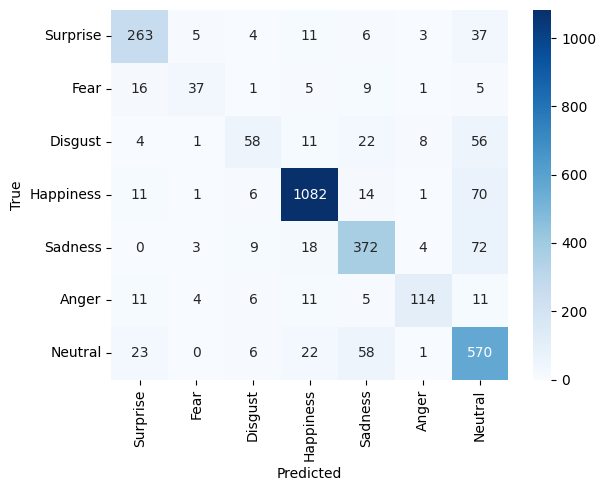

In [4]:

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_dict.values(), yticklabels=class_dict.values(), fmt='d', annot_kws={"fontsize":10})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Plot example images with predictions
# Get dataset from http://www.whdeng.cn/raf/model1.html to print examples
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, (img, pred_label, true_label, confidence) in enumerate(images):
    if i >= 9:
        break
    row = i // 3
    col = i % 3
    axs[row, col].imshow(img)
    axs[row, col].set_title(f"Pred.: {pred_label} ({confidence:.2f})\nTrue: {true_label}", fontsize=10)
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()